This notebook is accompanied with theory on my blog http://www.ataspinar.com.
In this notebook we will make use of the following datasets:
* [Air passengers dataset](https://www.kaggle.com/rakannimer/air-passengers)
* [Rossman store sales dataset](https://www.kaggle.com/pratyushakar/rossmann-store-sales)
* [Carbon emissions dataset](https://www.kaggle.com/txtrouble/carbon-emissions)

So go ahead and download those datasets and place them in a 'data' folder which is in the same folder as this notebook. 

## 0. Loading the datasets and a quick analysis

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small') 

In [2]:
from siml.detect_peaks import *
from siml.signal_analysis_utils import *

In [3]:
df_air = pd.read_csv('./data/AirPassengers.csv',
        parse_dates=['Month'], 
        date_parser=lambda x: pd.to_datetime(x, format='%Y-%m', errors = 'coerce'))
df_air = df_air.set_index('Month')

df_rossman = pd.read_csv('./data/rossmann-store-sales/train.csv',
            parse_dates=['Date'], 
            date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors = 'coerce'))
df_rossman = df_rossman.dropna(subset=['Store','Date'])

df_carbon = pd.read_csv('./data/carbon_emissions.csv',
            parse_dates=['YYYYMM'], 
            date_parser=lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce'))

df_carbon['Value'] = pd.to_numeric(df_carbon['Value'] , errors='coerce')
df_carbon = df_carbon.dropna(subset=['YYYYMM','Value'], how='any')
df_carbon.loc[:,'Description'] = df_carbon['Description'].apply(lambda x: x.split(',')[0].replace(' CO2 Emissions',''))


display(df_air.head(2))
display(df_carbon.head(2))
display(df_rossman.head(2))

/Users/ahmettaspinar/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118


,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLEIEUS,1973-01-01,72.076,1,Coal Electric Power Sector,Million Metric Tons of Carbon Dioxide
1,CLEIEUS,1973-02-01,64.442,1,Coal Electric Power Sector,Million Metric Tons of Carbon Dioxide


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


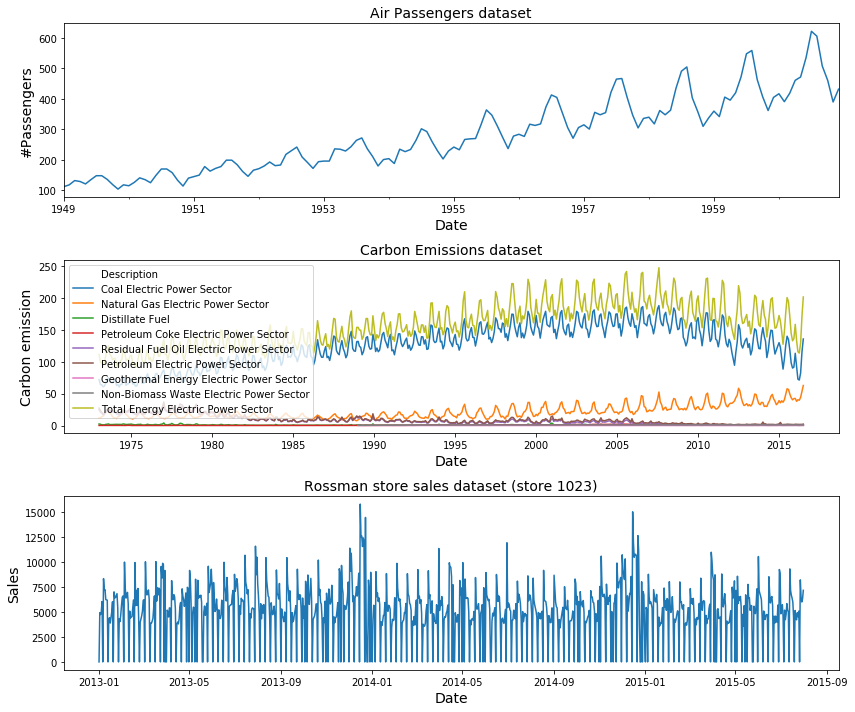

In [4]:
df_rossman_ = df_rossman[df_rossman['Store'] == 1023].sort_values(['Date'])

fig, axarr = plt.subplots(figsize=(12,10),nrows=3)
df_air['#Passengers'].plot(kind='line', ax=axarr[0])
sns.lineplot(data=df_carbon, x='YYYYMM', y='Value', hue='Description', ax=axarr[1])
sns.lineplot(data=df_rossman_, x='Date', y='Sales', ax=axarr[2])

axarr[1].legend(loc='upper left')

axarr[0].set_title('Air Passengers dataset', fontsize=14)
axarr[1].set_title('Carbon Emissions dataset', fontsize=14)
axarr[2].set_title('Rossman store sales dataset (store 1023)', fontsize=14)

axarr[0].set_xlabel('Date', fontsize=14)
axarr[1].set_xlabel('Date', fontsize=14)
axarr[2].set_xlabel('Date', fontsize=14)

axarr[0].set_ylabel('#Passengers', fontsize=14)
axarr[1].set_ylabel('Carbon emission', fontsize=14)
axarr[2].set_ylabel('Sales', fontsize=14)
plt.tight_layout()
plt.savefig('./signal_forecasting_figure1.png')
plt.show()

## 1. Detrending the Air passenger dataset.
In the blog we have seen that we first need to detrend the dataset (or substract the average value) before we can apply the Fourier Transform. 
In this section we will see different methods for detrending a dataset and decomposing it into trend and seasonal components. 

## 1.1 Detrending using stasmodels.seasonal_decompose()

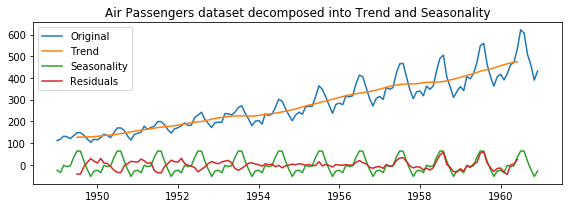

In [5]:
decomposition = seasonal_decompose(df_air)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df_air, label='Original')
ax.plot(trend, label='Trend')
ax.plot(seasonal, label='Seasonality')
ax.plot(residual, label='Residuals')
ax.legend(loc='best')
ax.set_title('Air Passengers dataset decomposed into Trend and Seasonality')
plt.tight_layout()
plt.show()

## 1.2 Detrending using Scipy's savgol filter

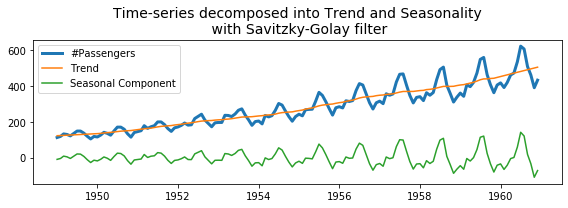

In [6]:
yvalues = df_air['#Passengers'].values
yvalues_trend = savgol_filter(yvalues,25,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df_air.index.values, yvalues, label='#Passengers',linewidth=3)
ax.plot(df_air.index.values, yvalues_trend, label='Trend')
ax.plot(df_air.index.values, yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()
#plt.savefig('./signal_forecasting_figure4.png')

## 1.3 detrending using pandas rolling() functions

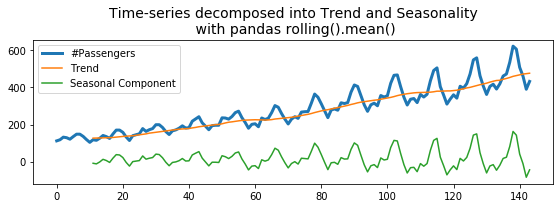

In [7]:
yvalues = df_air['#Passengers']
yvalues_trend = df_air['#Passengers'].rolling(window=12).mean()
yvalues_detrended = yvalues - yvalues_trend
xvalues = range(len(yvalues))

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xvalues, yvalues, label='#Passengers',linewidth=3)
ax.plot(xvalues, yvalues_trend, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with pandas rolling().mean()', fontsize=14)
plt.tight_layout()
plt.show()
#plt.savefig('./signal_forecasting_figure5.png')

## 1.5 detrending using numpy's polyfit()

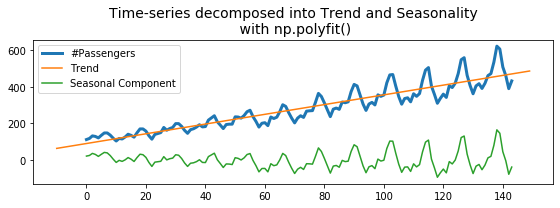

In [8]:
yvalues = df_air['#Passengers']
xvalues = range(len(yvalues))
xvalues_extended = range(-10,150)

z1 = np.polyfit(xvalues, yvalues, deg=1)
p1 = np.poly1d(z1)
yvalues_trend = p1(xvalues_extended)
yvalues_detrended = yvalues - p1(xvalues)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xvalues, yvalues, label='#Passengers',linewidth=3)
ax.plot(xvalues_extended, yvalues_trend, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with np.polyfit()', fontsize=14)
plt.tight_layout()
plt.show()
#plt.savefig('./signal_forecasting_figure5b.png')

## 1.6 detrending using only numpy matrix manipulations

Size of original time-series: 144 by 1
Size of reshaped array: 16 by 9
Size of reshaped array and averaged array: 16 by 1


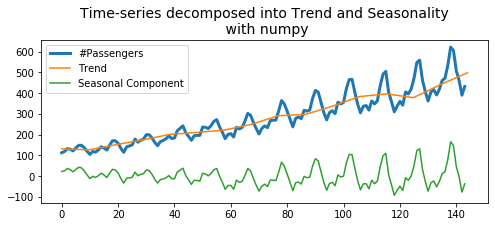

In [9]:
yvalues = df_air['#Passengers'].values
xvalues = range(len(yvalues))
yvalues_reshaped = yvalues.reshape(16,-1)
yvalues_mean = np.nanmean(yvalues_reshaped, axis=1)
xvalues_mean = np.linspace(0,len(yvalues),16)
print("Size of original time-series: {} by 1".format(*yvalues.shape))
print("Size of reshaped array: {} by {}".format(*yvalues_reshaped.shape))
print("Size of reshaped array and averaged array: {} by 1".format(*yvalues_mean.shape))

fig, ax = plt.subplots(figsize=(8,3))
ax.set_title('Time-series decomposed into Trend and Seasonality\n with numpy', fontsize=14)
ax.plot(xvalues, yvalues, label='#Passengers',linewidth=3)
ax.plot(xvalues_mean, yvalues_mean, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
plt.show()
#plt.savefig('./signal_forecasting_figure6.png')

## 2. Using the Fourier Transform to go from the time-domain to the frequency domain

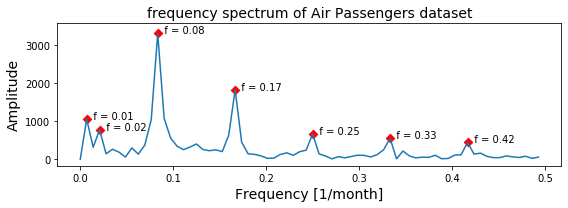

In [10]:
fraction_signal = 1.0
mph = 0.4
deg_polyfit= 1

yvalues = df_air['#Passengers'].values
fft_x, fft_y, p2 = construct_fft(yvalues, deg_polyfit)
#                                 integer_no_only=True, frac=fraction_signal, mph=mph)

indices_peaks = detect_peaks(fft_y, mph=430)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(fft_x, fft_y)
ax.scatter(fft_x[indices_peaks], fft_y[indices_peaks], color='red',marker='D')
ax.set_title('frequency spectrum of Air Passengers dataset', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_xlabel('Frequency [1/month]', fontsize=14)
for idx in indices_peaks:
    x,y = fft_x[idx], fft_y[idx]
    text = "  f = {:.2f}".format(x,y)
    ax.annotate(text, (x,y))
plt.tight_layout()
#plt.savefig('./signal_forecasting_figure8.png')
plt.show()

## 2.1 Reconstructing the Time-domain using np.fft.ifft()

/Users/ahmettaspinar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


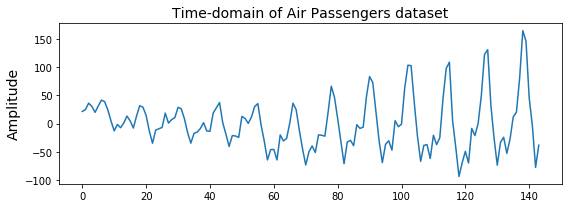

In [11]:
fft_y_  = np.fft.fft(yvalues_detrended)
inverse_fft = np.fft.ifft(fft_y_)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(inverse_fft, label='The inverse of the freq. spectrum')
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_title('Time-domain of Air Passengers dataset', fontsize=14)
plt.tight_layout()
#plt.savefig('./signal_forecasting_figure11.png')
plt.show()

## 2.2 Reconstructing the time-domain using np.fft.ifft() and parts of the frequency spectrum

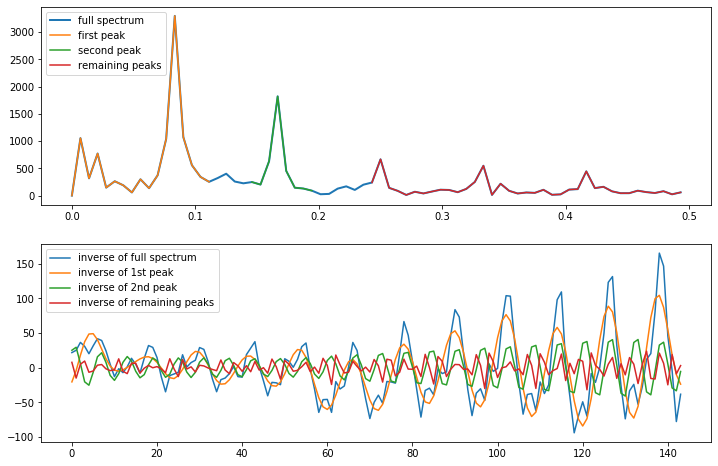

In [12]:
fig, axarr = plt.subplots(figsize=(12,8), nrows=2)
axarr[0].plot(fft_x, fft_y, linewidth=2, label='full spectrum')
axarr[0].plot(fft_x[:17], fft_y[:17], label='first peak')
axarr[0].plot(fft_x[21:29], fft_y[21:29], label='second peak')
axarr[0].plot(fft_x[35:], fft_y[35:], label='remaining peaks')
axarr[0].legend(loc='upper left')
fft_y_copy1 = fft_y_.copy()
fft_y_copy2 = fft_y_.copy()
fft_y_copy3 = fft_y_.copy()
fft_y_copy1[17:-17] = 0
fft_y_copy2[:21] = 0
fft_y_copy2[29:-29] = 0
fft_y_copy2[-21:] = 0
fft_y_copy3[:35] = 0
fft_y_copy3[-35:] = 0
inverse_fft = np.fft.ifft(fft_y_)
inverse_fft1 = np.fft.ifft(fft_y_copy1)
inverse_fft2 = np.fft.ifft(fft_y_copy2)
inverse_fft3 = np.fft.ifft(fft_y_copy3)
axarr[1].plot(inverse_fft, label='inverse of full spectrum')
axarr[1].plot(inverse_fft1, label='inverse of 1st peak')
axarr[1].plot(inverse_fft2, label='inverse of 2nd peak')
axarr[1].plot(inverse_fft3, label='inverse of remaining peaks')
axarr[1].legend(loc='upper left')
plt.show()
#plt.savefig('./signal_forecasting_figure12.png')

## 2.3 Reconstructing the time-domain using our own function

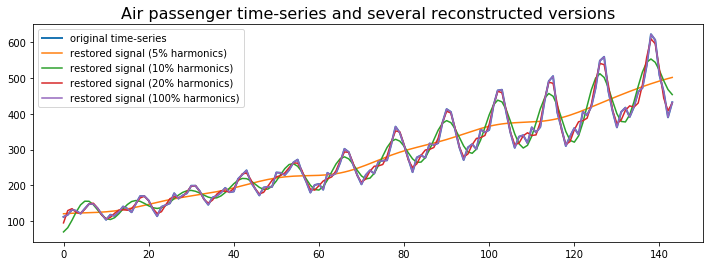

In [13]:
yvalues = df_air['#Passengers'].values
xvalues = np.arange(len(yvalues))
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(yvalues, linewidth=2, label='original time-series')

list_frac_harmonics = [0.05, 0.1, 0.2, 1.0]
for ii, frac_harmonic in enumerate(list_frac_harmonics):
    yvalues_restored = reconstruct_from_fft(yvalues, frac_harmonics=frac_harmonic)
    label = 'restored signal ({:.0f}% harmonics)'.format(100*frac_harmonic)
    ax.plot(yvalues_restored, label=label)
ax.legend(loc='upper left')
ax.set_title('Air passenger time-series and several reconstructed versions', fontsize=16)
plt.show()

## 3. Time-Series Forecasting on Rossman Store sales dataset

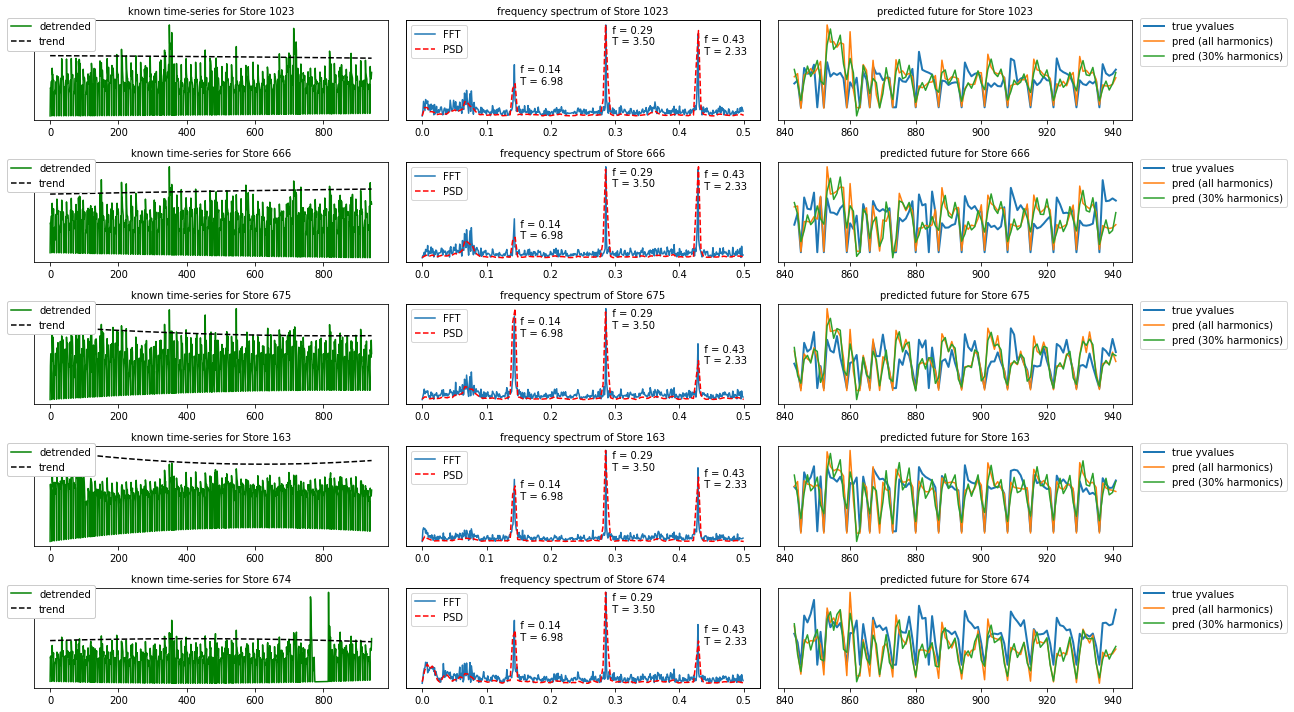

In [14]:
list_stores = df_rossman['Store'].value_counts().index.values
N = 843
nrows=5
ycol = 'Sales'
axtitle = 'Store {}'

fig, axarr = plt.subplots(figsize=(18,2*nrows), ncols=3, nrows=nrows)
for row_no, store in enumerate(list_stores[:nrows]):
    df_ = df_rossman[df_rossman['Store']==store].sort_values(['Date'])
    
    yvalues_full = df_[ycol].values
    xvalues_full = np.arange(len(yvalues_full))
    yvalues_known = yvalues_full[:N]
    xvalues_known = np.arange(len(yvalues_known))
    yvalues_future = yvalues_full[N:]
    xvalues_future = np.arange(N, len(xvalues_full))
    N_extrapolation = len(yvalues_future)
    yvalues_detrended = plot_yvalues(axarr[row_no, 0], xvalues_full, yvalues_full, plot_original=False, polydeg=2)
    fft_x_, fft_y_ = plot_fft_psd(axarr[row_no, 1], yvalues_detrended, plot_psd=True, max_peak=0.4)
    yvalues_predicted1 = reconstruct_from_fft(yvalues_known, extrapolate_with=N_extrapolation, fraction_signal=0.6)
    yvalues_predicted2 = reconstruct_from_fft(yvalues_known, extrapolate_with=N_extrapolation, fraction_signal=0.6, frac_harmonics=0.3)
    axarr[row_no,2].plot(xvalues_future, yvalues_future, label='true yvalues', linewidth=2)
    axarr[row_no,2].plot(xvalues_future, yvalues_predicted1, label='pred (all harmonics)')
    axarr[row_no,2].plot(xvalues_future, yvalues_predicted2, label='pred (30% harmonics)')
    title = axtitle.format(store)
    axarr[row_no,0].set_title('known time-series for {}'.format(title),fontsize=10)
    axarr[row_no,1].set_title('frequency spectrum of {}'.format(title),fontsize=10)
    axarr[row_no,2].set_title('predicted future for {}'.format(title),fontsize=10)
    axarr[row_no,2].set_yticks([])
    axarr[row_no,2].legend(loc='upper left', bbox_to_anchor=(1.01, 1.078))
plt.tight_layout()
#plt.savefig('./rossman_store_sales2.png')
plt.show()

## 4. Time-series forecasting on the Carbon dataset

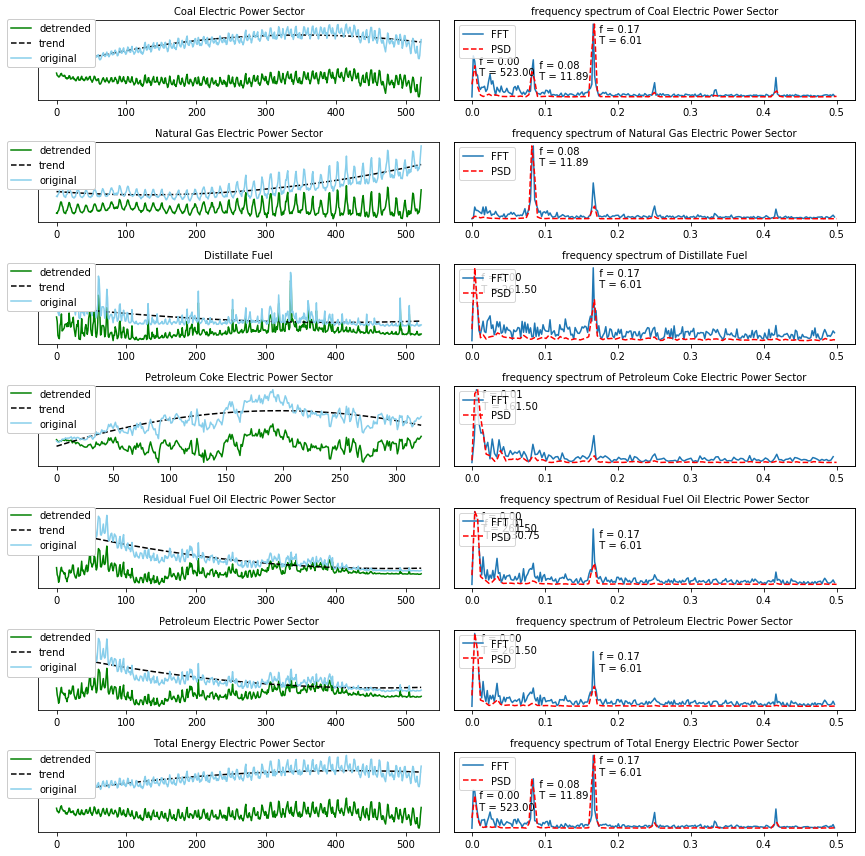

In [15]:
source_types = [
'Coal Electric Power Sector', 
'Natural Gas Electric Power Sector',
'Distillate Fuel', 
'Petroleum Coke Electric Power Sector',
'Residual Fuel Oil Electric Power Sector',
'Petroleum Electric Power Sector',
'Total Energy Electric Power Sector'
]

dict_yvalues = {}
N = 200
ycol = 'Value'
fig, axarr = plt.subplots(figsize=(12,12), nrows=7, ncols=2)
for ii, desc in enumerate(source_types):
    df_ = df_carbon[df_carbon['Description'] == desc]
    yvalues = df_[ycol].values
    if desc == 'Petroleum Coke Electric Power Sector':
        yvalues = yvalues[N:]
    xvalues = np.arange(len(yvalues))
    
    yvalues_detrended = plot_yvalues(axarr[ii,0], xvalues, yvalues, plot_original=True, polydeg=2)
    plot_fft_psd(axarr[ii,1], yvalues_detrended, plot_psd=True)
    axarr[ii,0].set_title(desc,fontsize=10)
    axarr[ii,1].set_title('frequency spectrum of {}'.format(desc),fontsize=10)
plt.tight_layout()
#plt.savefig('./signal_forecasting_figure13.png')
plt.show()

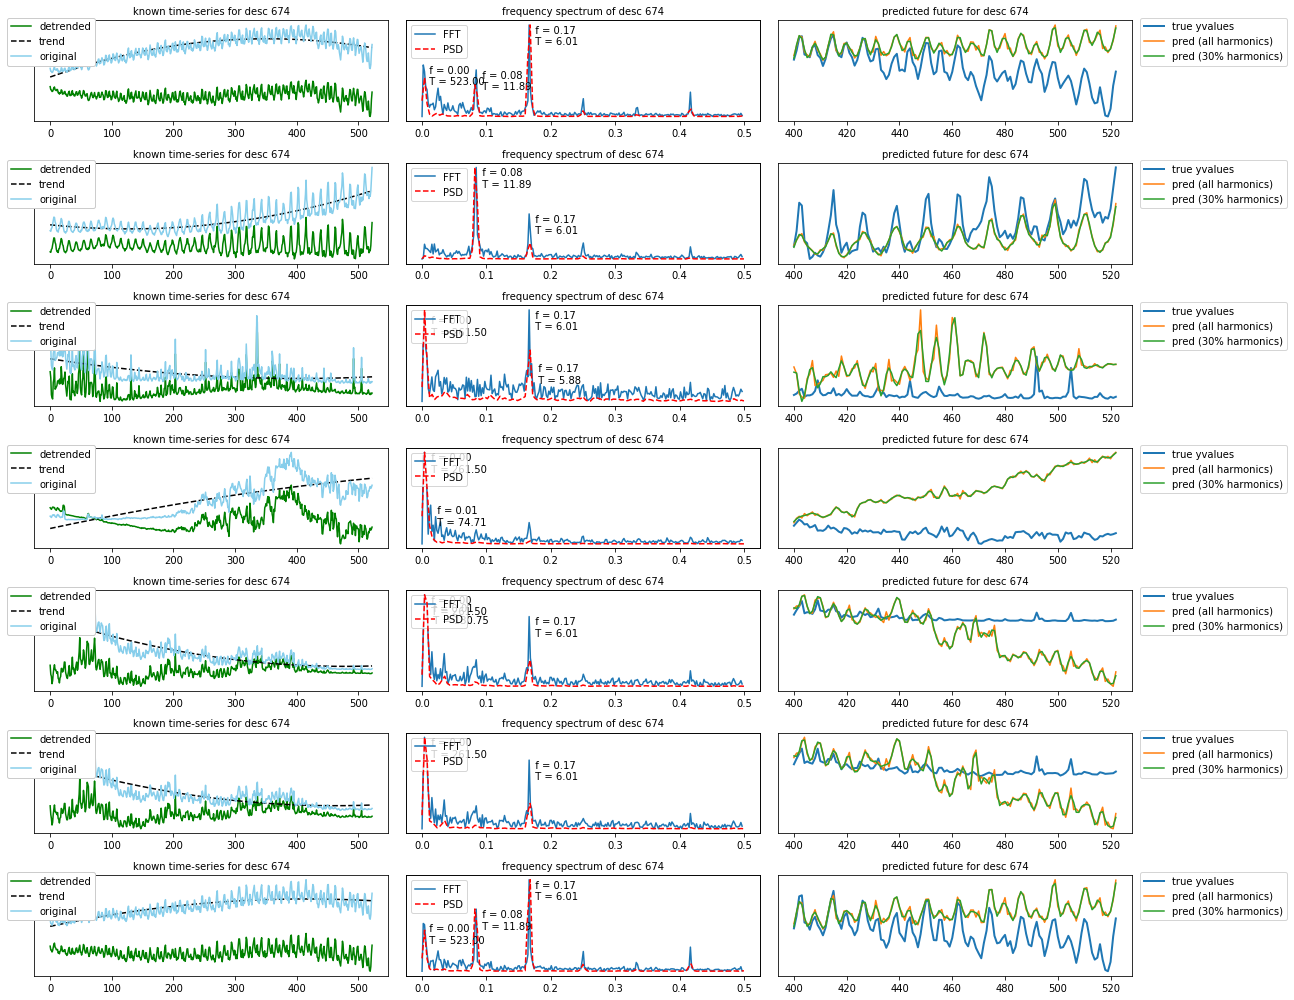

In [16]:
N = 400
nrows=len(source_types)
frac_harmonics = 0.3
fraction_signal = 0.6
max_peak = 0.4
ycol = 'Value'
axtitle = 'desc {}'
fig, axarr = plt.subplots(figsize=(18,2*nrows), ncols=3, nrows=nrows)
for row_no, desc in enumerate(source_types):
    df_ = df_carbon[df_carbon['Description'] == desc]
    yvalues_full = df_[ycol].values
    xvalues_full = np.arange(len(yvalues_full))
    yvalues_known = yvalues_full[:N]
    xvalues_known = np.arange(len(yvalues_known))
    yvalues_future = yvalues_full[N:]
    xvalues_future = np.arange(N, len(xvalues_full))
    N_extrapolation = len(yvalues_future)
    yvalues_detrended = plot_yvalues(axarr[row_no, 0], xvalues_full, yvalues_full, plot_original=True, polydeg=2)
    fft_x_, fft_y_ = plot_fft_psd(axarr[row_no, 1], yvalues_detrended, plot_psd=True, max_peak=max_peak)
    yvalues_predicted1 = reconstruct_from_fft(yvalues_known, extrapolate_with=N_extrapolation, fraction_signal=fraction_signal)
    yvalues_predicted2 = reconstruct_from_fft(yvalues_known, extrapolate_with=N_extrapolation, fraction_signal=fraction_signal, frac_harmonics=frac_harmonics)
    axarr[row_no,2].plot(xvalues_future, yvalues_future, label='true yvalues', linewidth=2)
    axarr[row_no,2].plot(xvalues_future, yvalues_predicted1, label='pred (all harmonics)')
    axarr[row_no,2].plot(xvalues_future, yvalues_predicted2, label='pred (30% harmonics)')
    title = axtitle.format(store)
    axarr[row_no,0].set_title('known time-series for {}'.format(title),fontsize=10)
    axarr[row_no,1].set_title('frequency spectrum of {}'.format(title),fontsize=10)
    axarr[row_no,2].set_title('predicted future for {}'.format(title),fontsize=10)
    axarr[row_no,2].set_yticks([])
    axarr[row_no,2].legend(loc='upper left', bbox_to_anchor=(1.01, 1.078))
plt.tight_layout()
plt.savefig(f'./carbon_emission_prediction_.png')
plt.show()
plt.close()